# ДВУХЛУЧЕВАЯ ИНТЕРФЕРОМЕТРИЯ

## Гомодинный интерферометр 
### Задание: измерить амплитуду колебаний зеркала, частоту  

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import t 
import os, sys



In [2]:
data = np.loadtxt(os.path.join(sys.path[0] +'/data', 'C2-homodyne-00000.txt'))
time, signal = data[:,0],data[:,1]
del data

Фотоприемник, помещенный на пути суммарной волны, преобразует интенсивность выходного сигнала интерферометра в электрический сигнал: $$U(t) = U_0+U_n\cdot\cos{\phi(t)}$$
Уберем постоянную составляющую, а также множитель, чтобы получить косинус

In [3]:
time = time - np.min(time)
signal = signal - np.min(signal)
signal = signal - 1/2 * (np.max(signal) - np.min(signal))
signal = signal/((np.max(signal) - np.min(signal))/2)

In [4]:
print(np.max(signal), np.min(signal))

1.0 -1.0


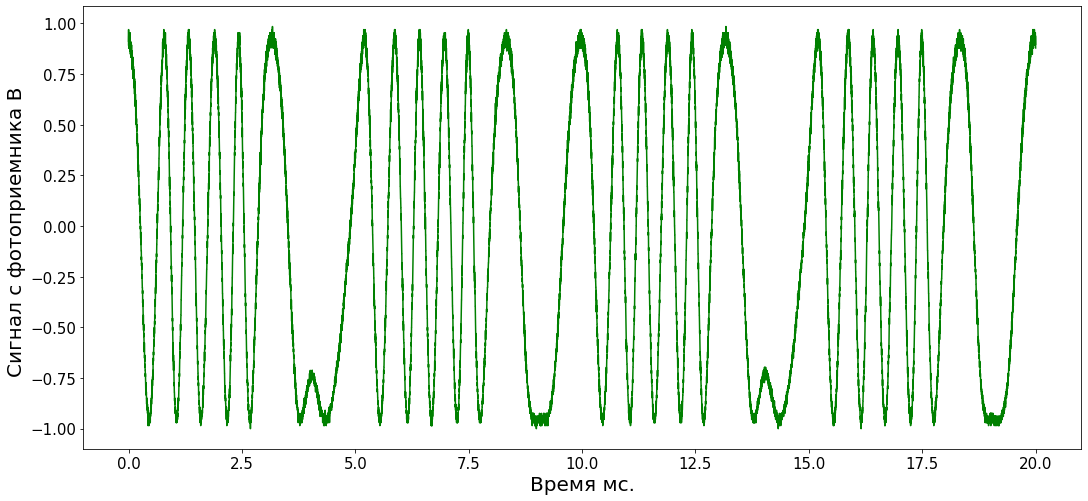

In [5]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Время мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Сигнал с фотоприемника В ",fontweight='light',color='k', fontsize=20)
ax.plot(time[:20000]*10**3, signal[:20000],c='g')
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_1_full_signal.png'))

Сигнал можно немного пофильтровать низкачастотным фильтром 

In [6]:
hs = np.fft.rfft(signal)
fs = np.fft.rfftfreq(len(time), time[1])

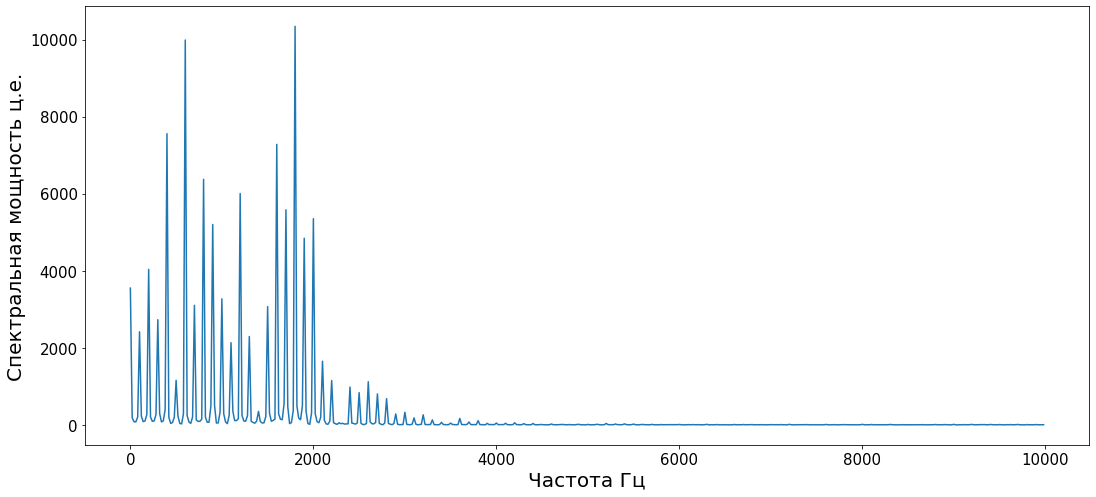

In [7]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Частота Гц',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Спектральная мощность ц.е.",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.plot(fs[:500], abs(hs[:500]))
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_1_full_signal_fourier.png'))

Обнулим частоты выше 6 ГГц

In [8]:
hs[300:]=0
signal = np.fft.irfft(hs)

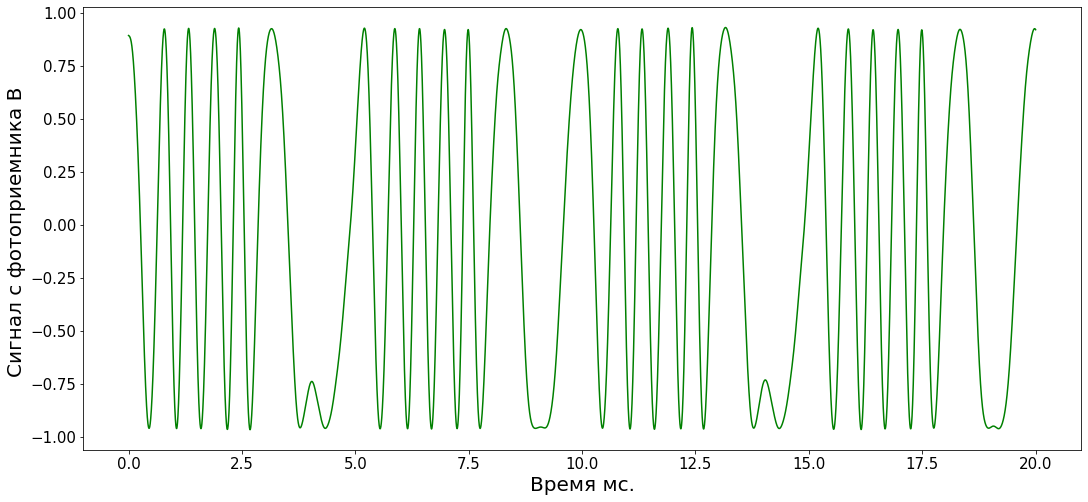

In [9]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Время мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Сигнал с фотоприемника В ",fontweight='light',color='k', fontsize=20)
ax.plot(time[:20000]*10**3, signal[:20000],c='g')
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_1_full_signal_filtred.png'))

In [10]:
print(np.min(signal), np.max(signal))

-0.965370539577493 0.9320970105975029


Сигнал немного испортился, поэтому нужно вернуть его в прежнее состояние, чтобы взять арккосинус

In [11]:
signal = signal - 1/2 * (np.max(signal) + np.min(signal))
signal = signal/((np.max(signal) - np.min(signal))/2)

In [12]:
print(np.min(signal), np.max(signal))

-1.0 1.0


In [13]:
phi = np.arccos(signal)
print(np.min(phi), np.max(phi))

0.0 3.141592653589793


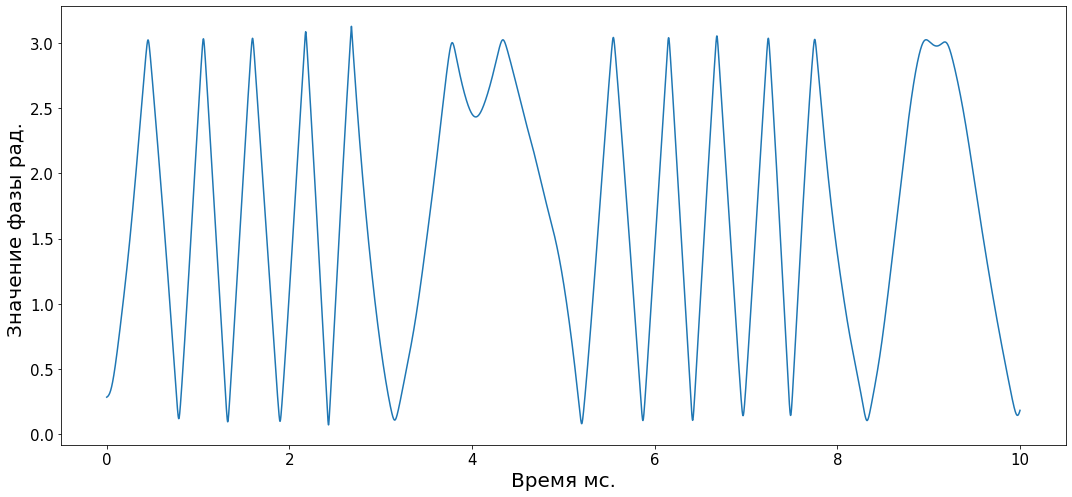

In [14]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Время мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Значение фазы рад. ",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.plot(time[:10000]*10**3, phi[:10000])
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_1_arccos_signal_filtred.png'))

В настоящее время сшить в автоматическом режиме эту фазу не представляется возможным, а ручками делать это я не очень хочу, но видно, что сигнал синусоидальный. Поэтому амплитуду смещения зеркала можно определить по количеству периодов из первого графика 

In [15]:
#unwrap = np.unwrap(phi, period = np.pi)
#fig = plt.figure(figsize=(15, 10))
#ax = fig.add_subplot(1,1,1)
#ax.plot(time[:10000], unwrap[:10000])
#ax.plot(time, phi)

Согласно формуле:
$$\Delta X = (N+\frac{\Delta \phi}{2\cdot\pi})\cdot\frac{\lambda}{2} $$
необходмо сосчитать, сколько периодов между точками разворота 

cos проходит 6 периодов, поэтому амплитуда колебаний зеркала будет равна


In [16]:
wavelength = 632.8e-9 #м
X =  6*wavelength/2
D_X  = wavelength/2 # погрешность - половина длины волны 

определим частоту колебаний зеркала 

In [17]:
from scipy.signal import find_peaks

In [18]:

min_ind,_ = find_peaks(signal, distance=100, height=(-0.9, 0))

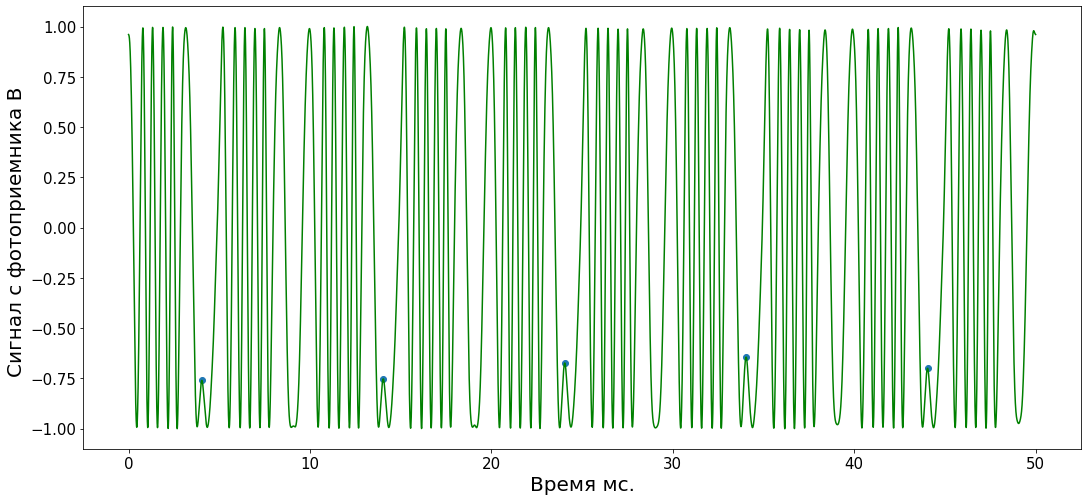

In [19]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Время мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Сигнал с фотоприемника В ",fontweight='light',color='k', fontsize=20)
ax.plot(time[:]*10**3, signal[:],c='g')
ax.scatter(time[min_ind]*10**3,signal[min_ind] )
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)

In [20]:
from scipy.stats import t 
import math
def stat_error(data, conf_prob):
    #conf_prob - Доверительная вероятность  
    n = len(data)
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data)
    interval = student_coef * math.sqrt((var)/n)
    return interval

In [21]:
freq = 1 / np.diff(time[min_ind])
freq_mean = np.mean(freq)
D_freq = stat_error(freq, conf_prob=0.99)

итого

In [22]:
print(f'Амплитуда колебаний зеркала = {X} +-{D_X}')
print(f'Частота колебаний зеркала = {freq_mean} +- {D_freq}')
print('Тип сигнала - синусоидальный')

Амплитуда колебаний зеркала = 1.8984e-06 +-3.164e-07
Частота колебаний зеркала = 99.99251174457426 +- 0.0976307456933
Тип сигнала - синусоидальный


 ### Гетеродинный  интерферометр

#### Задание 1: измерить амплитуду колебаний зеркала, частоту 

In [23]:
data_gen = np.loadtxt(os.path.join(sys.path[0] +'/data', 'C3-heterodyne1-gen-00000.txt'))
data_opt = np.loadtxt(os.path.join(sys.path[0] +'/data', 'C2-heterodyne1-opt-00000.txt'))


In [24]:
time = data_gen[:,0] - np.min(data_gen[:,0])
time = time[:-1]
s_gen = data_gen[:-1,1]
s_opt = data_opt[:-1,1]
del data_gen, data_opt

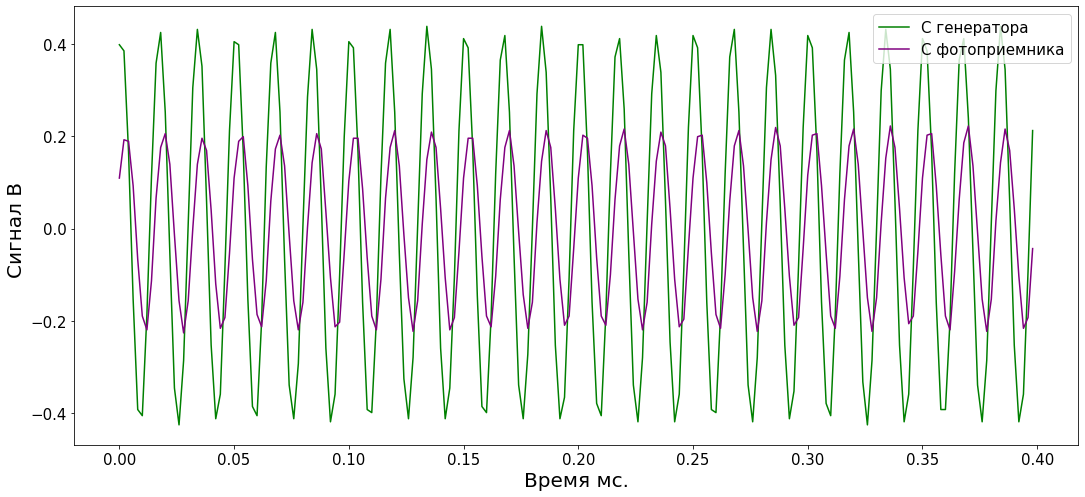

In [25]:
fig = plt.figure(figsize=(15, 7 ))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Время мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Сигнал В ",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
ax.plot(time[:200]*10**6, s_gen[:200],c='g',label = 'С генератора')
ax.plot(time[:200]*10**6, s_opt[:200],c='purple',label = 'С фотоприемника' )
ax.legend(prop={'size': 15})
plt.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.1_full_signals.png'))

Сделаем преобразование Гильберта от косинуса(сигнал с генератора), чтобы получить ортогональную функцию 

In [26]:
from scipy.signal import hilbert
s_gen_hilb = hilbert(s_gen)
s_gen_hilb = s_gen_hilb.imag

перемножим теперь синус и косинус с информативным сигналом, чтобы достать синусискомой фазы и косинус

In [27]:
signal_cos = s_gen*s_opt
signal_sin = s_gen_hilb*s_opt
del s_gen,s_gen_hilb, s_opt

в этих сигналах есть и компонента на удвоенной частоте несущей, ее нужно отфильтровать 

In [28]:
hs_cos = np.fft.rfft(signal_cos)
fs_cos = np.fft.rfftfreq(len(time), time[1])
hs_sin = np.fft.rfft(signal_sin)
fs_sin = np.fft.rfftfreq(len(time), time[1])

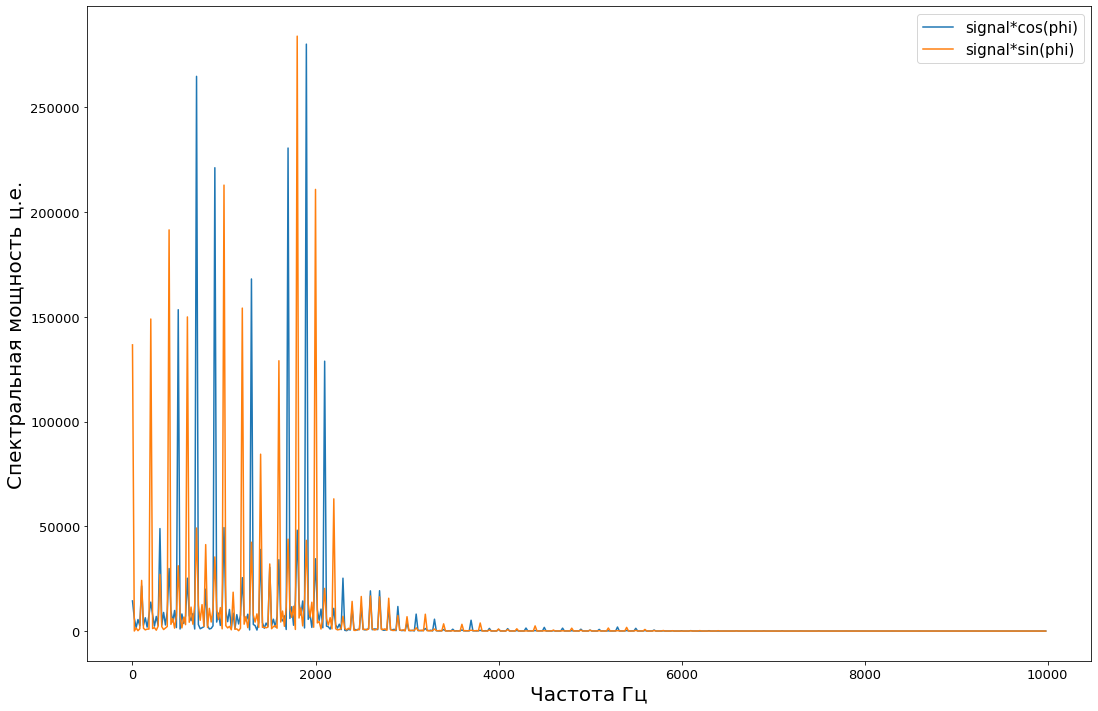

In [29]:
#Полезная часть фурье-спектра сигнала
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Частота Гц',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Спектральная мощность ц.е.",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=13)
ax.plot(fs_cos[:500], abs(hs_cos[:500]), label = 'signal*cos(phi)')
ax.plot(fs_cos[:500], abs(hs_sin[:500]), label = 'signal*sin(phi)')
ax.legend(prop={'size': 15})
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.1_fourier_2 signals_product.png'))

In [30]:
fs_cos[1000]

19999.99997583265

Отфильтруем всё, что ниже  20 кГц пороговым фильтром

In [31]:
hs_cos[1000:] = 0
hs_sin[1000:] = 0
print(len(hs_sin))
fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(1,1,1)
# ax.plot(fs_cos, abs(hs_cos))
f_signal_cos = np.fft.irfft(hs_cos)
f_signal_sin = np.fft.irfft(hs_sin)
print(len(f_signal_sin))

12500001
25000000


<Figure size 1080x720 with 0 Axes>

In [32]:
del hs_cos,hs_sin,fs_sin,fs_cos, signal_cos, signal_sin

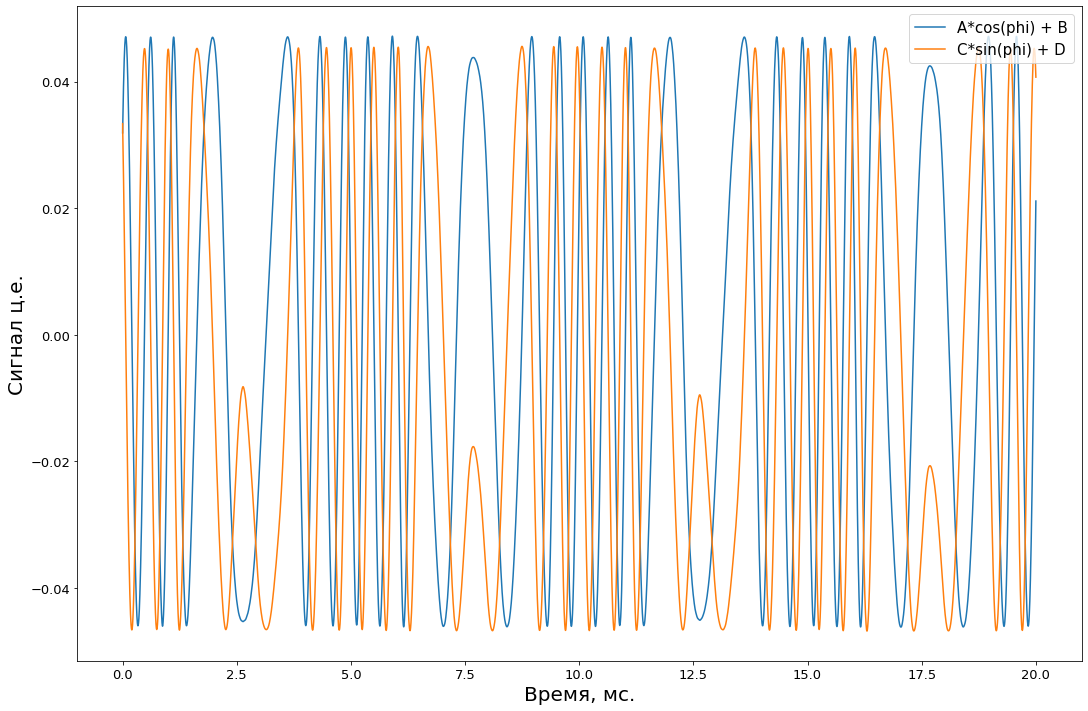

In [33]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Время, мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Сигнал ц.е.",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=13)
ax.plot(time[:10000000]*1e3, f_signal_cos[:10000000], label = 'A*cos(phi) + B')
ax.plot(time[:10000000]*1e3, f_signal_sin[:10000000], label = 'C*sin(phi) + D')
ax.legend(loc=1, prop={'size': 15})
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.1_filtred_2 signals_product.png'))

Найдем теперь эти коэффициенты, чтобы сигналы стали чистыми sin и cos 

In [34]:
print(np.max(f_signal_cos))
print(np.min(f_signal_cos))
print(np.max(f_signal_sin))
print(np.min(f_signal_sin))

0.047254093875135565
-0.04625652356417401
0.04562249885120919
-0.046815311327566535


In [35]:
f_signal_cos = (f_signal_cos -(np.max(f_signal_cos)+np.min(f_signal_cos)))/((np.max(f_signal_cos)-np.min(f_signal_cos))/2)
f_signal_sin = (f_signal_sin -(np.max(f_signal_sin)+np.min(f_signal_sin)))/((np.max(f_signal_sin)-np.min(f_signal_sin))/2)

In [36]:
print(np.max(f_signal_cos))
print(np.min(f_signal_cos))
print(np.max(f_signal_sin))
print(np.min(f_signal_sin))

0.9893320102221653
-1.0106679897778346
1.0129039456262587
-0.9870960543737413


При хорошо скомпенсированных коэффициентах фазовая кривая для сигнала должна быть окружностью 

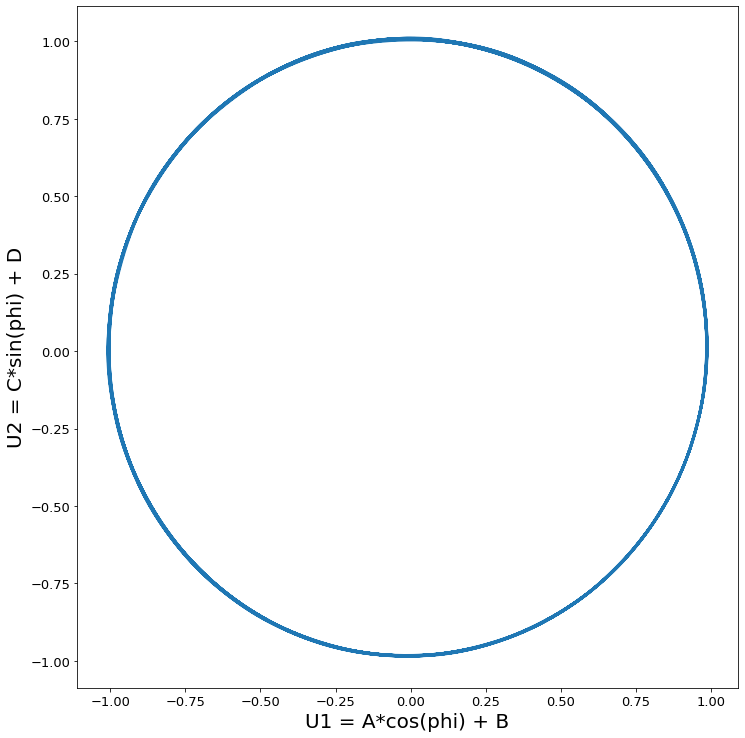

In [37]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(f_signal_cos,f_signal_sin)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('U1 = A*cos(phi) + B',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("U2 = C*sin(phi) + D",fontweight='light',color='k', fontsize=20)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.1_phase_curve.png'))

теперь чтобы получить фазу слепим из sin и cos тангенс и возьмем арктангенс 

In [38]:
signal_arctan = np.arctan2(f_signal_sin, f_signal_cos)

In [39]:
del f_signal_sin, f_signal_cos

In [40]:
def two_pi_range(angles):
    return (2*np.pi + angles) * (angles < 0) + angles*(angles > 0)
signal_arctan = two_pi_range(signal_arctan)

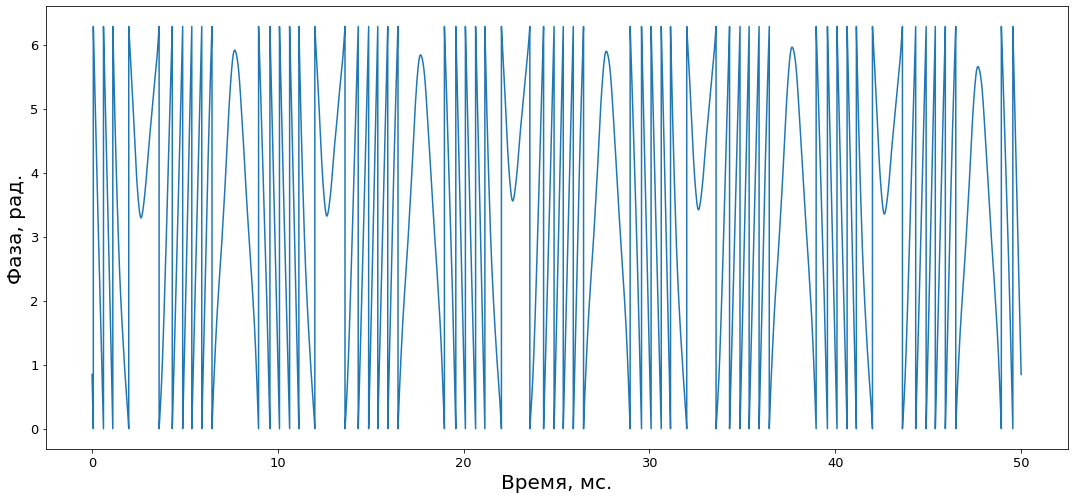

In [41]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.plot(time*1e+3, signal_arctan)
ax.set_xlabel('Время, мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Фаза, рад.",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=13)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.1_wraped pase.png'))

Арктангенс получается сшить

In [42]:
 signal_arctan = np.unwrap(signal_arctan, period=2*np.pi) 

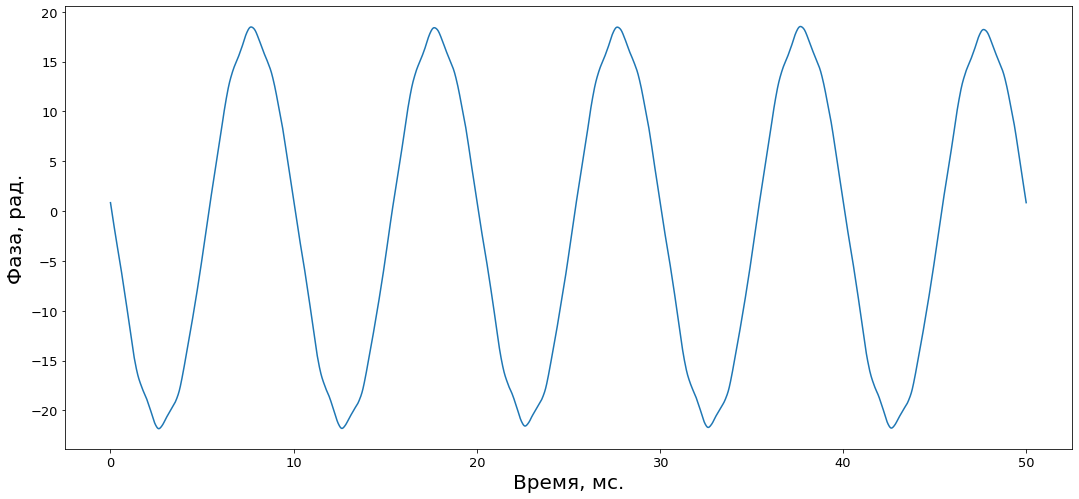

In [43]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.plot(time*1e+3, signal_arctan)
ax.set_xlabel('Время, мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Фаза, рад.",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=13)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.1_unwraped pase.png'))

Видим, что сигнал синусоидальный, дело за малым. Осталось определить частоту и амплитуду

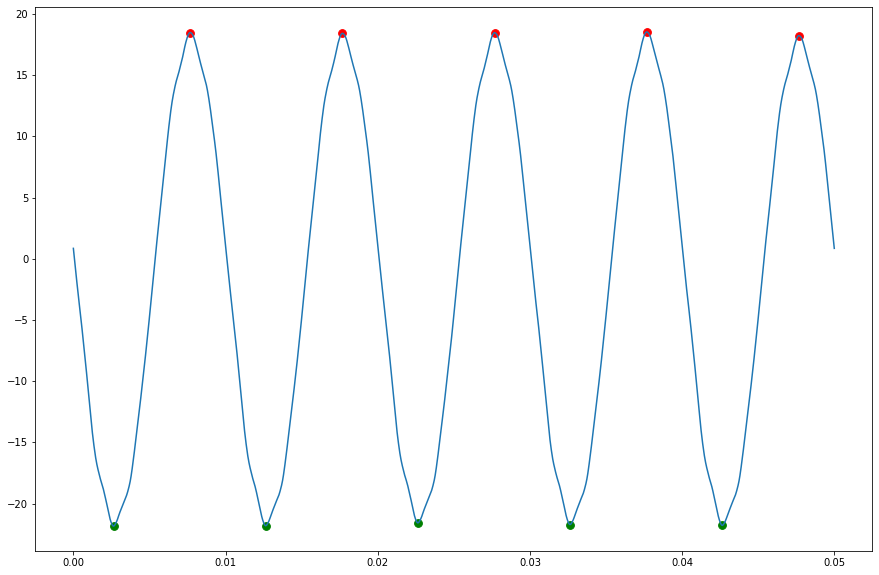

In [44]:
from scipy.signal import find_peaks
max_ind,_ = find_peaks(signal_arctan, distance=1000000, height = 15)
min_ind,_ = find_peaks(-signal_arctan, distance=1000000, height = 15)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time, signal_arctan)
ax.scatter(time[max_ind], signal_arctan[max_ind], c='r', s=60)
ax.scatter(time[min_ind], signal_arctan[min_ind], c='g',s=60)

In [45]:
from scipy.stats import t 
import math
def stat_error(data, conf_prob):
    #conf_prob - Доверительная вероятность  
    n = len(data)
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data)
    interval = student_coef * math.sqrt((var)/n)
    return interval

In [46]:
#Если количество максимумов и минимумов одинаковое,то 
amp = signal_arctan[max_ind] - signal_arctan[min_ind]
amp_mean = np.mean(amp)
D_amp_stat = stat_error(amp, conf_prob=0.99)

In [47]:
freq = 1 / np.diff(time[max_ind])
freq_mean = np.mean(freq)
D_freq = stat_error(freq, conf_prob=0.99)

In [48]:
mirr_amp = (amp_mean)*wavelength/(4*np.pi)
D_mirr_amp = D_amp_stat*wavelength/(4*np.pi)
print(f"Амплитуда колебаний зеркала = {mirr_amp} +- {D_mirr_amp} м")
print(f'Частота колебаний зеркала = {freq_mean} +- {D_freq} Гц')
print('Сигнал, подаваемый на зеркало - синусоидальный ')

Амплитуда колебаний зеркала = 2.0224835962358994e-06 +- 1.2623304619519242e-08 м
Частота колебаний зеркала = 100.0079726707839 +- 0.0774648275198873 Гц
Сигнал, подаваемый на зеркало - синусоидальный 


#### Задание 2: измерить амплитуду колебаний зеркала, частоту, однако ни частота, ни вид сигнала - неизвестны 

Аналогичено предыдущему заданию

In [49]:
data_gen = np.loadtxt(os.path.join(sys.path[0] +'/data', 'C3-heterodyne2-gen-00000.txt'))
data_opt = np.loadtxt(os.path.join(sys.path[0] +'/data', 'C2-heterodyne2-opt-00000.txt'))

In [50]:
time = data_gen[:,0] - np.min(data_gen[:,0])
time = time[:-1]
s_gen = data_gen[:-1,1]
s_opt = data_opt[:-1,1]
del data_gen, data_opt

In [51]:
print(len(s_gen))

5000000


In [52]:
from scipy.signal import hilbert
s_gen_hilb = hilbert(s_gen)
s_gen_hilb = s_gen_hilb.imag

In [53]:
signal_cos = s_gen*s_opt
signal_sin = s_gen_hilb*s_opt
del s_gen,s_gen_hilb, s_opt

In [54]:
hs_cos = np.fft.rfft(signal_cos)
fs_cos = np.fft.rfftfreq(len(time), time[1])
hs_sin = np.fft.rfft(signal_sin)
fs_sin = np.fft.rfftfreq(len(time), time[1])

In [55]:
hs_cos[1000:] = 0
hs_sin[1000:] = 0
print(len(hs_sin))
f_signal_cos = np.fft.irfft(hs_cos)
f_signal_sin = np.fft.irfft(hs_sin)
print(len(f_signal_sin))

2500001
5000000


In [56]:
del hs_cos,hs_sin,fs_sin,fs_cos, signal_cos, signal_sin

In [57]:
print(np.max(f_signal_cos))
print(np.min(f_signal_cos))
print(np.max(f_signal_sin))
print(np.min(f_signal_sin))

0.0500386704343421
-0.048963148754091176
0.047868561602504814
-0.04882663191526962


In [58]:
f_signal_cos = (f_signal_cos -(np.max(f_signal_cos)+np.min(f_signal_cos)))/((np.max(f_signal_cos)-np.min(f_signal_cos))/2)
f_signal_sin = (f_signal_sin -(np.max(f_signal_sin)+np.min(f_signal_sin)))/((np.max(f_signal_sin)-np.min(f_signal_sin))/2)

In [59]:
print(np.max(f_signal_cos))
print(np.min(f_signal_cos))
print(np.max(f_signal_sin))
print(np.min(f_signal_sin))

0.9891363442705648
-1.010863655729435
1.0099081482533947
-0.9900918517466052


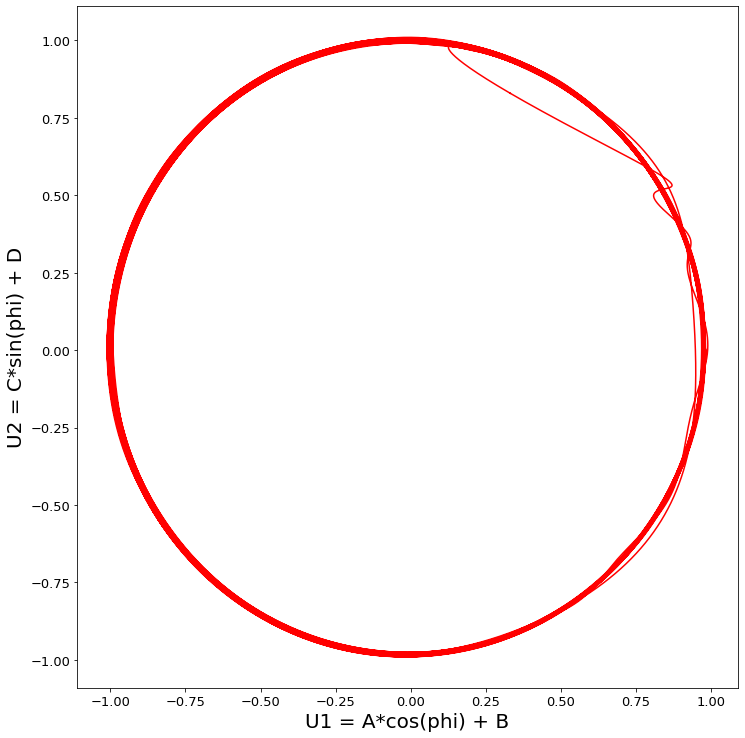

In [60]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(f_signal_cos,f_signal_sin, c='r')
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('U1 = A*cos(phi) + B',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("U2 = C*sin(phi) + D",fontweight='light',color='k', fontsize=20)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.2_phase_curve.png'))

In [61]:
signal_arctan = np.arctan2(f_signal_sin, f_signal_cos)

In [62]:
del f_signal_sin, f_signal_cos

In [63]:
def two_pi_range(angles):
    return (2*np.pi + angles) * (angles < 0) + angles*(angles > 0)
signal_arctan = two_pi_range(signal_arctan)

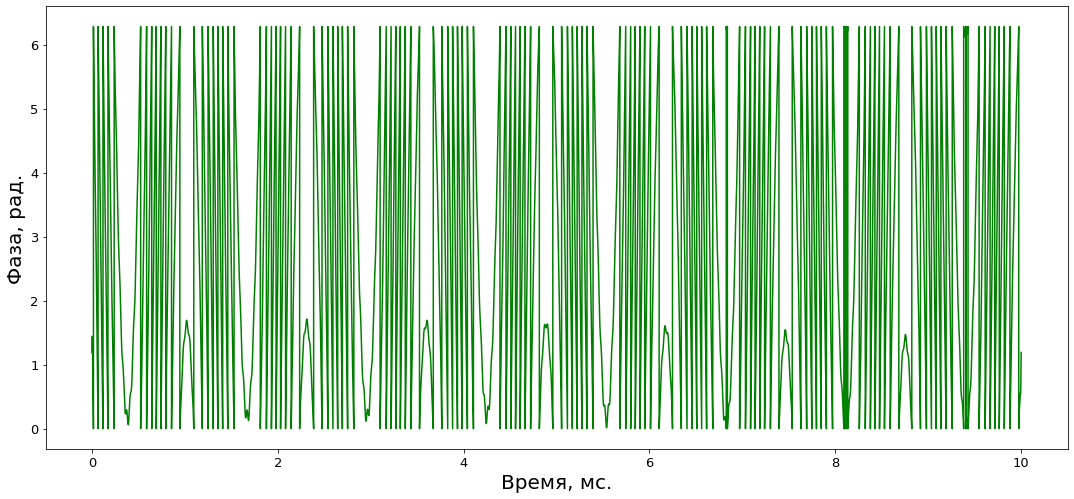

In [64]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.plot(time*1e+3, signal_arctan,c='g')
ax.set_xlabel('Время, мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Фаза, рад.",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=13)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.2_wraped pase.png'))

In [65]:
 signal_arctan = np.unwrap(signal_arctan, period=2*np.pi) 

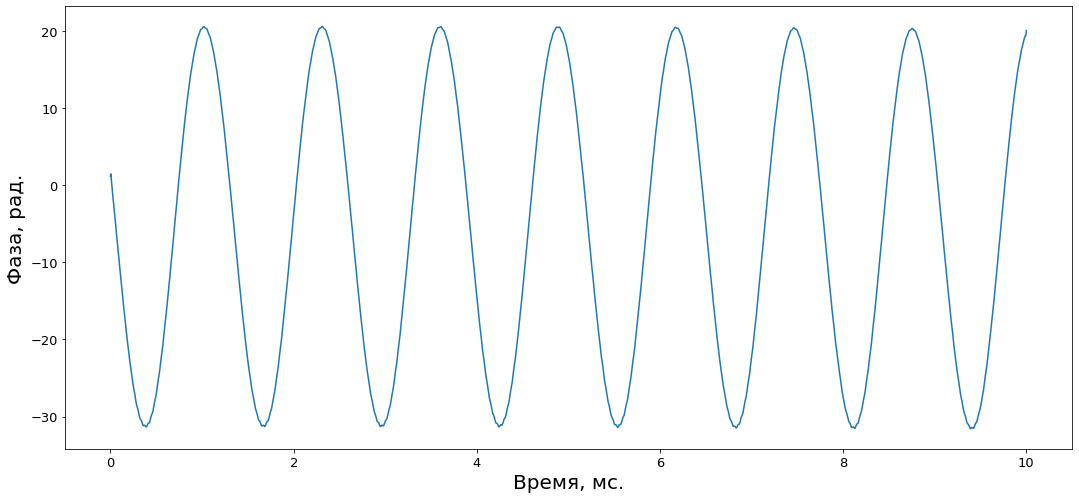

In [66]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1,1,1)
ax.plot(time*1e+3, signal_arctan)
ax.set_xlabel('Время, мс.',fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Фаза, рад.",fontweight='light',color='k', fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=13)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'task_2.2_unwraped pase.png'))

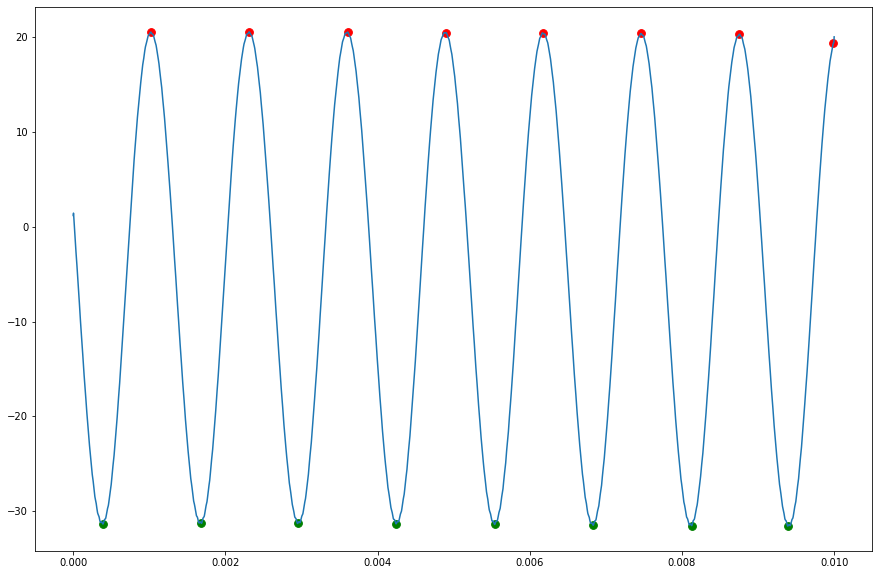

In [67]:
from scipy.signal import find_peaks
max_ind,_ = find_peaks(signal_arctan, distance=100000, height = 15)
min_ind,_ = find_peaks(-signal_arctan, distance=100000, height = 15)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time, signal_arctan)
ax.scatter(time[max_ind], signal_arctan[max_ind], c='r', s=60)
ax.scatter(time[min_ind], signal_arctan[min_ind], c='g',s=60)

In [68]:
from scipy.stats import t 
import math
def stat_error(data, conf_prob):
    #conf_prob - Доверительная вероятность  
    n = len(data)
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data)
    interval = student_coef * math.sqrt((var)/n)
    return interval

In [69]:
#Если количество максимумов и минимумов одинаковое,то 
amp = signal_arctan[max_ind] - signal_arctan[min_ind]
amp_mean = np.mean(amp)
D_amp_stat = stat_error(amp, conf_prob=0.99)

In [70]:
freq = 1 / np.diff(time[max_ind])
freq_mean = np.mean(freq)
D_freq = stat_error(freq, conf_prob=0.99)

In [71]:
wavelength = 632.8e-9
mirr_amp = (amp_mean)*wavelength/(4*np.pi)
D_mirr_amp = D_amp_stat*wavelength/(4*np.pi)
print(f"Амплитуда колебаний зеркала = {mirr_amp} +- {D_mirr_amp} м")
print(f'Частота колебаний зеркала = {freq_mean} +- {D_freq} Гц')
print('Сигнал, подаваемый на зеркало - пилообразный ')

Амплитуда колебаний зеркала = 2.6058521201839894e-06 +- 1.803655254738486e-08 м
Частота колебаний зеркала = 780.3107020179079 +- 18.16750554287645 Гц
Сигнал, подаваемый на зеркало - пилообразный 
